# CNN2ID基于CNN的网络攻击检测

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import logging
from tqdm import tqdm

import sys
sys.path.append('../..')
import random

from logger import setup_logging
from models import MLP
from utils import (
    dataset,
    test,
    train,
    train_copy,
    utils,
    visualisation
)

/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

check GPU is available?

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

In [5]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=True)

#选择一部分作为呀征集采样
random_seed = 123  # 设置随机种子值
random.seed(random_seed)
np.random.seed(random_seed)
val_subset_indices = np.random.choice(len(val_data), size=int(0.3 * len(train_data)), replace=False)
test_subset_indices = np.random.choice(len(test_data), size=int(0.3 * len(train_data)), replace=False)

val_subset = Subset(val_data, val_subset_indices)
test_subset = Subset(test_data, test_subset_indices)
# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))
print('# instances in validation set: ', len(val_subset))
print('# instances in testing set: ', len(test_subset))

batch_size = 128#之前是64，我感觉改成256也可以

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  140000
# instances in validation set:  485146
# instances in testing set:  485145
# instances in validation set:  42000
# instances in testing set:  42000


In [6]:
#Create model
class CNN2ID(nn.Module):
    def __init__(self):
        super(CNN2ID, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels = 64, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.maxpool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels = 64, out_channels=64, kernel_size=5, padding=2)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.maxpool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*64, 64)#应该是这里的问题
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 7)#64, 3
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.maxpool1(x)
        
        x = self.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool2(x)
        
        x = self.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.maxpool3(x)
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        
        return x

In [7]:
model = CNN2ID()
# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
#optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Epochs
num_epochs = 5

In [8]:
from tqdm import tqdm
import logging
def train1(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    #logging.basicConfig(level=logging.INFO)
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for inputs, labels in tqdm(train_loader):
            #对input进行变换
            inputs = inputs.reshape(len(inputs), 1, inputs.shape[1])
            labels = labels.view(-1)
            inputs, labels = inputs.to(device), labels.to(device)#放入device cuda中
            
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_loss += loss.cpu().item()
            train_loss += loss.item()
            train_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #train_output_pred += outputs.argmax(1).cpu().tolist()
            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()
        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader):
                inputs = inputs.reshape(len(inputs), 1, inputs.shape[1])#对inputs进行变换
                labels = labels.view(-1)
                inputs, labels = inputs.to(device), labels.to(device)
                #labels = labels.squeeze(1)
                
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

In [17]:
#得到X_train, X_val, X_test
X_train = train_data.features
X_val = val_data.features
X_test = test_data.features

y_train = train_data.labels
y_val = val_data.labels
y_test = test_data.labels

y_test = y_test.squeeze()
y_val = y_val.squeeze()

#reshape the data for CNN pytorch
X_train = X_train.to_numpy().reshape(len(X_train), 1, X_train.shape[1])
X_val = X_val.to_numpy().reshape(len(X_val), 1, X_val.shape[1])
X_test = X_test.to_numpy().reshape(len(X_test), 1, X_test.shape[1])
X_train.shape, X_test.shape

#训练函数
def train2(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        num_samples = X_train.shape[0]

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for batch in tqdm(range(num_samples // batch_size)):
            start_index = batch * batch_size
            end_index = (batch + 1) * batch_size
            inputs = torch.tensor(X_train[start_index:end_index], dtype=torch.float32)
            labels = torch.tensor(y_train.values[start_index:end_index], dtype=torch.long)

            optimizer.zero_grad()  # 梯度清零

            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            _, predicted = torch.max(outputs, 1)
            #acc = torch.sum(preds ==labels.data) / labels.size(0)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            train_loss += loss.item()
            train_steps += 1

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()

        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for batch in tqdm(range(X_test.shape[0] // batch_size)):
                start_index = batch * batch_size
                end_index = (batch + 1) * batch_size
                inputs = torch.tensor(X_test[start_index:end_index], dtype=torch.float32)
                labels = torch.tensor(y_test.values[start_index:end_index], dtype=torch.long)

                outputs = model(inputs)  # 前向传播
                loss = criterion(outputs, labels)  # 计算损失
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs, 1)  # 预测结果
                #acc = torch.sum(preds == labels.data) / labels.size(0)  # 计算准确率
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

### Train it

In [18]:
device = 'cpu'
history = train2(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-03-27 18:56:11,288 | 3075746052.py:62 | Epoch 1/5:


100%|██████████| 7580/7580 [00:20<00:00, 367.57it/s]

INFO 2024-03-27 18:56:53,884 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:56:53,888 | 3075746052.py:62 | Epoch 2/5:



100%|██████████| 7580/7580 [00:20<00:00, 369.99it/s]

INFO 2024-03-27 18:57:36,118 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:57:36,119 | 3075746052.py:62 | Epoch 3/5:



100%|██████████| 7580/7580 [00:20<00:00, 369.00it/s]

INFO 2024-03-27 18:58:18,374 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:58:18,378 | 3075746052.py:62 | Epoch 4/5:



100%|██████████| 7580/7580 [00:20<00:00, 375.77it/s]

INFO 2024-03-27 18:58:59,864 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:58:59,866 | 3075746052.py:62 | Epoch 5/5:



100%|██████████| 7580/7580 [00:20<00:00, 364.94it/s]

INFO 2024-03-27 18:59:42,638 | 3075746052.py:129 | loss: 2.0225323977729857 - acc: 0.14288980338363055 - val_loss: 1.3262607267318112 - val_acc: 0.839161444591029
INFO 2024-03-27 18:59:42,640 | 3075746052.py:131 | Finished Training


In [9]:
device = 'cpu'
history = train1(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-03-29 16:50:48,932 | 2040591022.py:44 | Epoch 1/5:


  0%|          | 0/1094 [00:00<?, ?it/s]/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 329/329 [00:08<00:00, 37.04it/s]

INFO 2024-03-29 16:51:23,275 | 2040591022.py:110 | loss: 1.192851092523369 - acc: 0.9777 - val_loss: 1.208119982644055 - val_acc: 0.9571904761904761
INFO 2024-03-29 16:51:23,277 | 2040591022.py:44 | Epoch 2/5:



100%|██████████| 329/329 [00:09<00:00, 35.00it/s]

INFO 2024-03-29 16:51:58,375 | 2040591022.py:110 | loss: 1.178552951738647 - acc: 0.9869071428571429 - val_loss: 1.2054678219792327 - val_acc: 0.9602380952380952
INFO 2024-03-29 16:51:58,377 | 2040591022.py:44 | Epoch 3/5:



100%|██████████| 329/329 [00:09<00:00, 36.16it/s]

INFO 2024-03-29 16:52:33,469 | 2040591022.py:110 | loss: 1.1785244208367258 - acc: 0.9869571428571429 - val_loss: 1.2092187908282759 - val_acc: 0.9558571428571428
INFO 2024-03-29 16:52:33,471 | 2040591022.py:44 | Epoch 4/5:



100%|██████████| 329/329 [00:09<00:00, 35.43it/s]

INFO 2024-03-29 16:53:08,413 | 2040591022.py:110 | loss: 1.1783307130419576 - acc: 0.9870285714285715 - val_loss: 1.2009210322040917 - val_acc: 0.9645714285714285
INFO 2024-03-29 16:53:08,416 | 2040591022.py:44 | Epoch 5/5:



100%|██████████| 329/329 [00:09<00:00, 36.48it/s]

INFO 2024-03-29 16:53:42,917 | 2040591022.py:110 | loss: 1.1778292536081736 - acc: 0.9875857142857143 - val_loss: 1.2495593296358287 - val_acc: 0.9154761904761904
INFO 2024-03-29 16:53:42,919 | 2040591022.py:112 | Finished Training


### Plot loss vs iterations

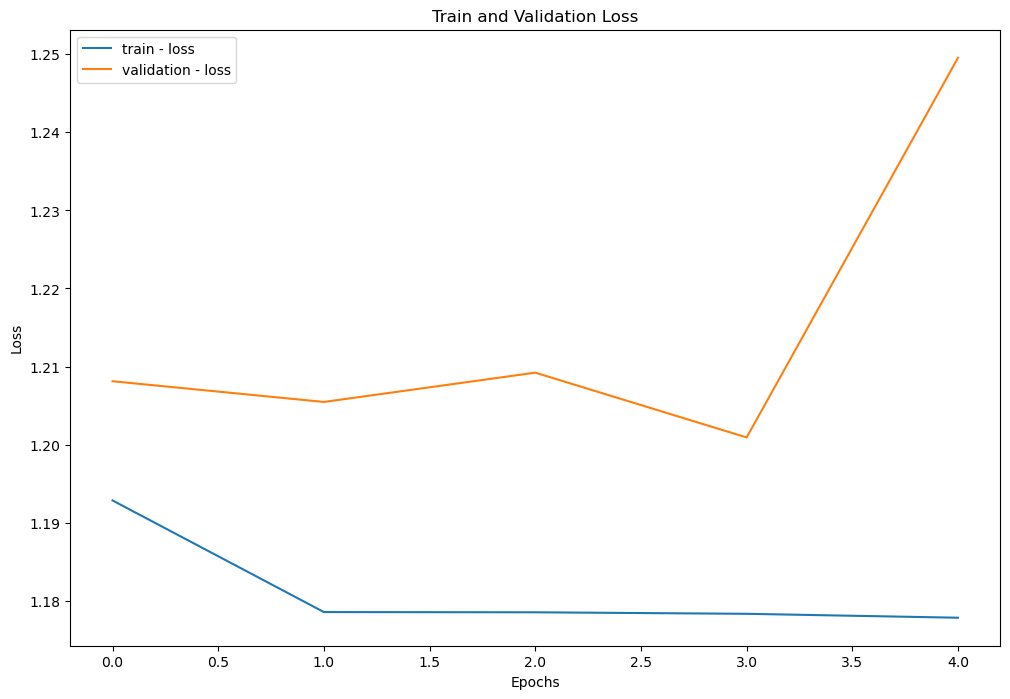

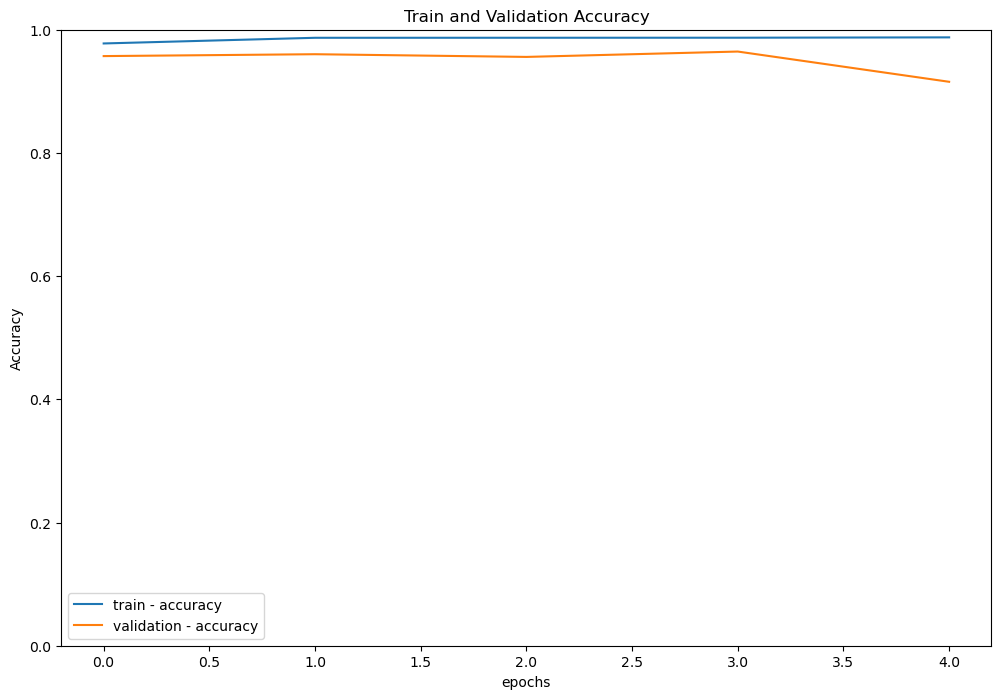

In [11]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.savefig('Train and Validation Loss2.pdf')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.savefig('Train and Validation Accuracy2.pdf')
plt.show()

### Plot confusion matrix

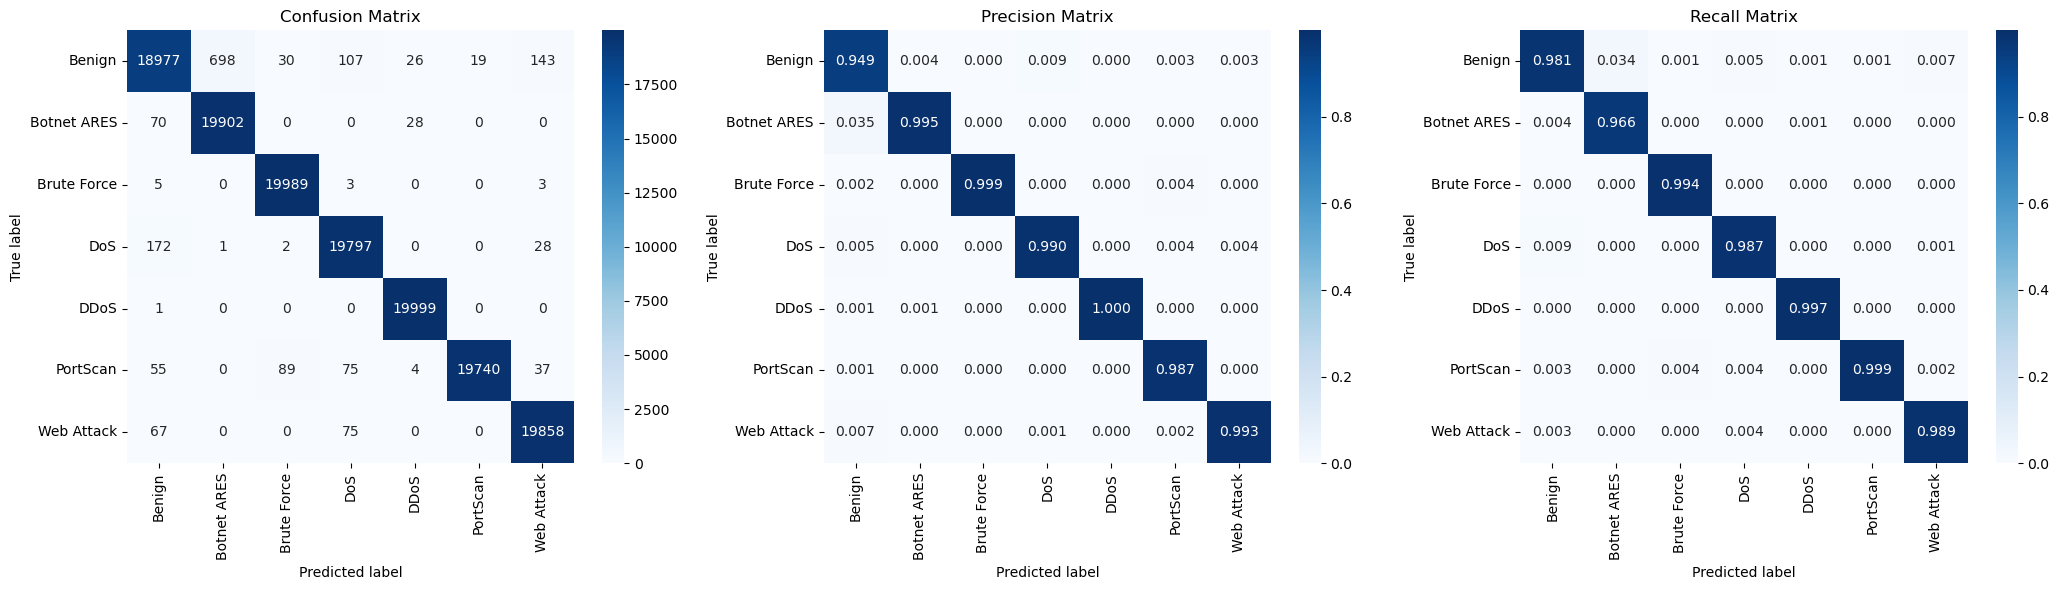

In [12]:
#labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS', 'DDoS', 'PortScan', 'Web Attack']
visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_train_confusion_matrix2.pdf")

In [13]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       0.98      0.95      0.96     20000
 Botnet ARES       0.97      1.00      0.98     20000
 Brute Force       0.99      1.00      1.00     20000
         DoS       0.99      0.99      0.99     20000
        DDoS       1.00      1.00      1.00     20000
    PortScan       1.00      0.99      0.99     20000
  Web Attack       0.99      0.99      0.99     20000

    accuracy                           0.99    140000
   macro avg       0.99      0.99      0.99    140000
weighted avg       0.99      0.99      0.99    140000



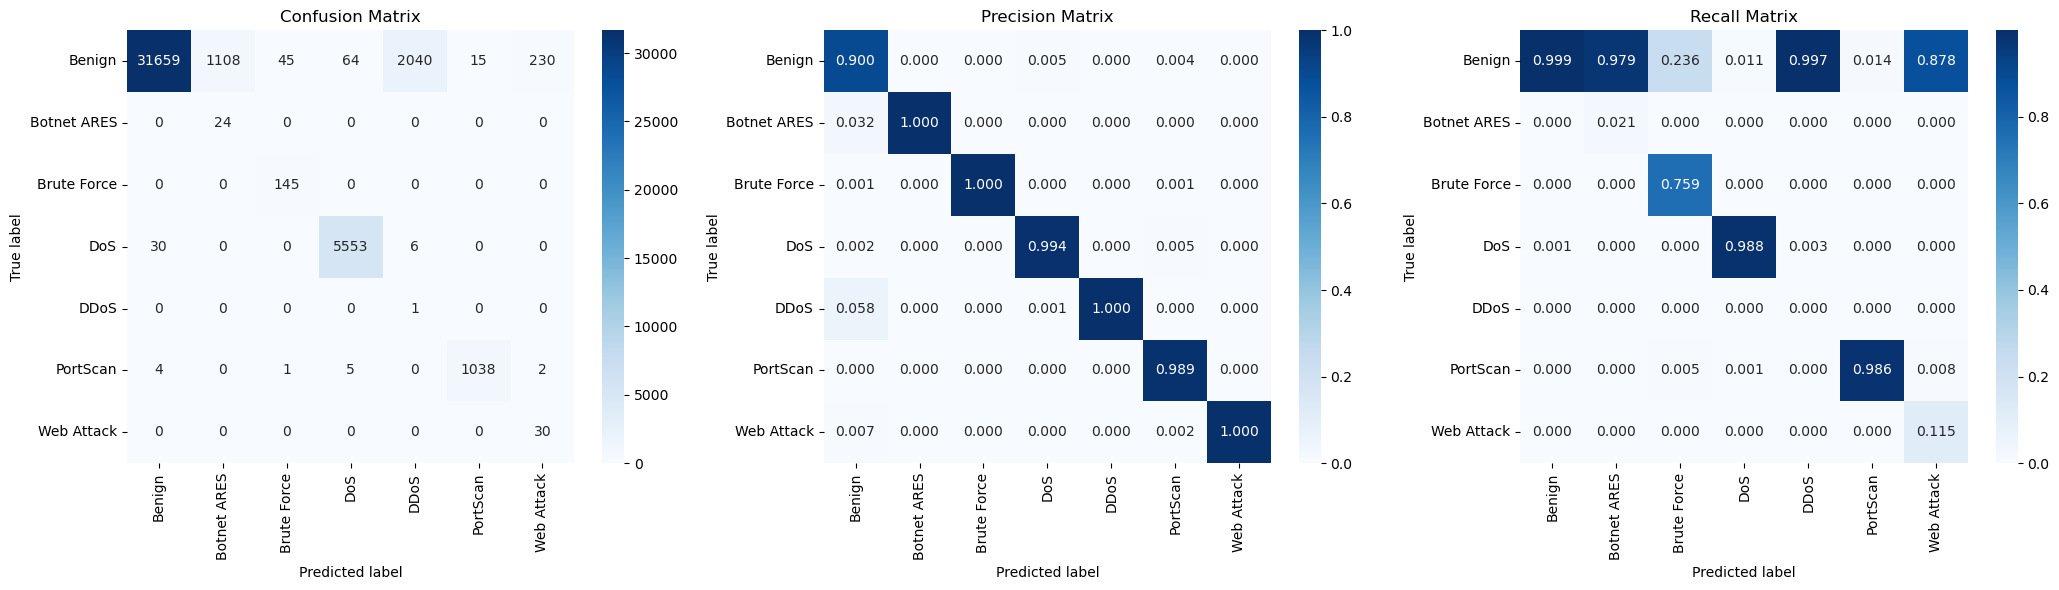

In [14]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_valid_confusion_matrix2.pdf")

In [15]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.90      0.95     35161
 Botnet ARES       0.02      1.00      0.04        24
 Brute Force       0.76      1.00      0.86       145
         DoS       0.99      0.99      0.99      5589
        DDoS       0.00      1.00      0.00         1
    PortScan       0.99      0.99      0.99      1050
  Web Attack       0.11      1.00      0.21        30

    accuracy                           0.92     42000
   macro avg       0.55      0.98      0.58     42000
weighted avg       1.00      0.92      0.95     42000



test it

In [16]:
#################
### TEST LOOP ###
#################
def test1(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
):

    model.eval()

    history = {
        'test': {
            'total': 0,
            'loss': 0.0,
            'accuracy': 0.0,
            'output_pred': [],
            'output_true': [],
            'output_pred_prob': []
        }
    }

    test_loss = 0.0
    test_steps = 0
    test_total = 0
    test_correct = 0

    test_output_pred = []
    test_output_true = []
    test_output_pred_prob = []

    with torch.no_grad():
        for (inputs, labels) in tqdm(test_loader):
            inputs = inputs.reshape(len(inputs), 1, inputs.shape[1])
            labels = labels.view(-1)
            #labels = labels.squeeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.cpu().item()
            test_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            test_output_pred += outputs.argmax(1).cpu().tolist()
            test_output_true += labels.tolist()
            test_output_pred_prob += nn.functional.softmax(outputs, dim=0).cpu().tolist()

    history['test']['total'] = test_total
    history['test']['loss'] = test_loss/test_steps
    history['test']['accuracy'] = test_correct/test_total
    history['test']['output_pred'] = test_output_pred
    history['test']['output_true'] = test_output_true
    history['test']['output_pred_prob'] = test_output_pred_prob

    logging.info(f'Test loss: {test_loss/test_steps}, Test accuracy: {test_correct/test_total}')

    return history
history = test1(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████| 3791/3791 [01:40<00:00, 37.71it/s]

INFO 2024-03-29 17:05:41,890 | 3572072708.py:61 | Test loss: 1.2512798086064247, Test accuracy: 0.9138237021921282


classificatiuon report

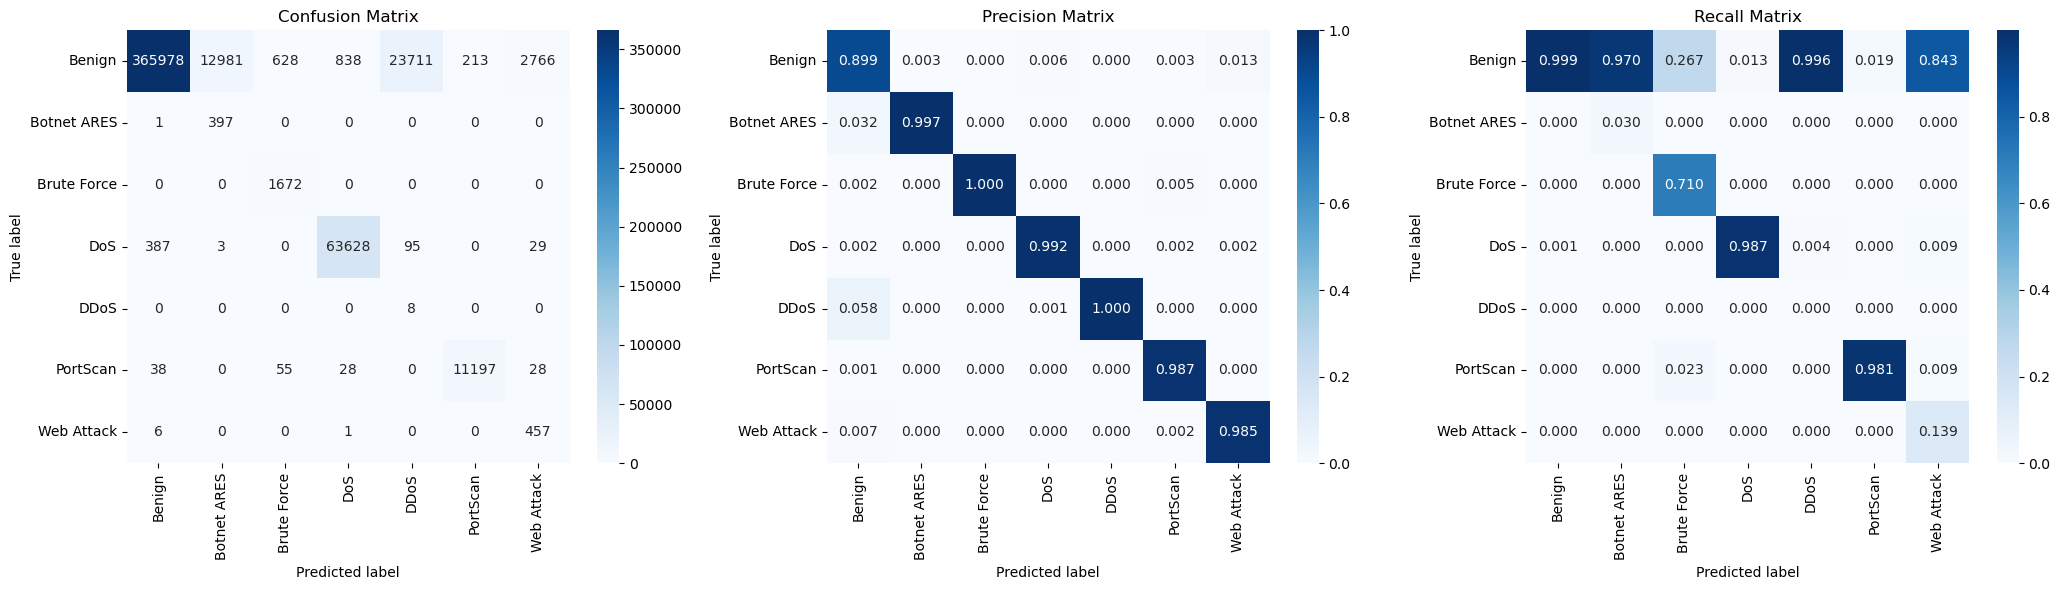

In [17]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_test_confusion_matrix2.pdf")

In [18]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.90      0.95    407115
 Botnet ARES       0.03      1.00      0.06       398
 Brute Force       0.71      1.00      0.83      1672
         DoS       0.99      0.99      0.99     64142
        DDoS       0.00      1.00      0.00         8
    PortScan       0.98      0.99      0.98     11346
  Web Attack       0.14      0.98      0.24       464

    accuracy                           0.91    485145
   macro avg       0.55      0.98      0.58    485145
weighted avg       0.99      0.91      0.95    485145



### Plot ROC

In [19]:
set(test_output_true)

{0, 1, 2, 3, 4, 5, 6}

In [20]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)
y_test.shape, y_score.shape

((485145, 7), (485145, 7))

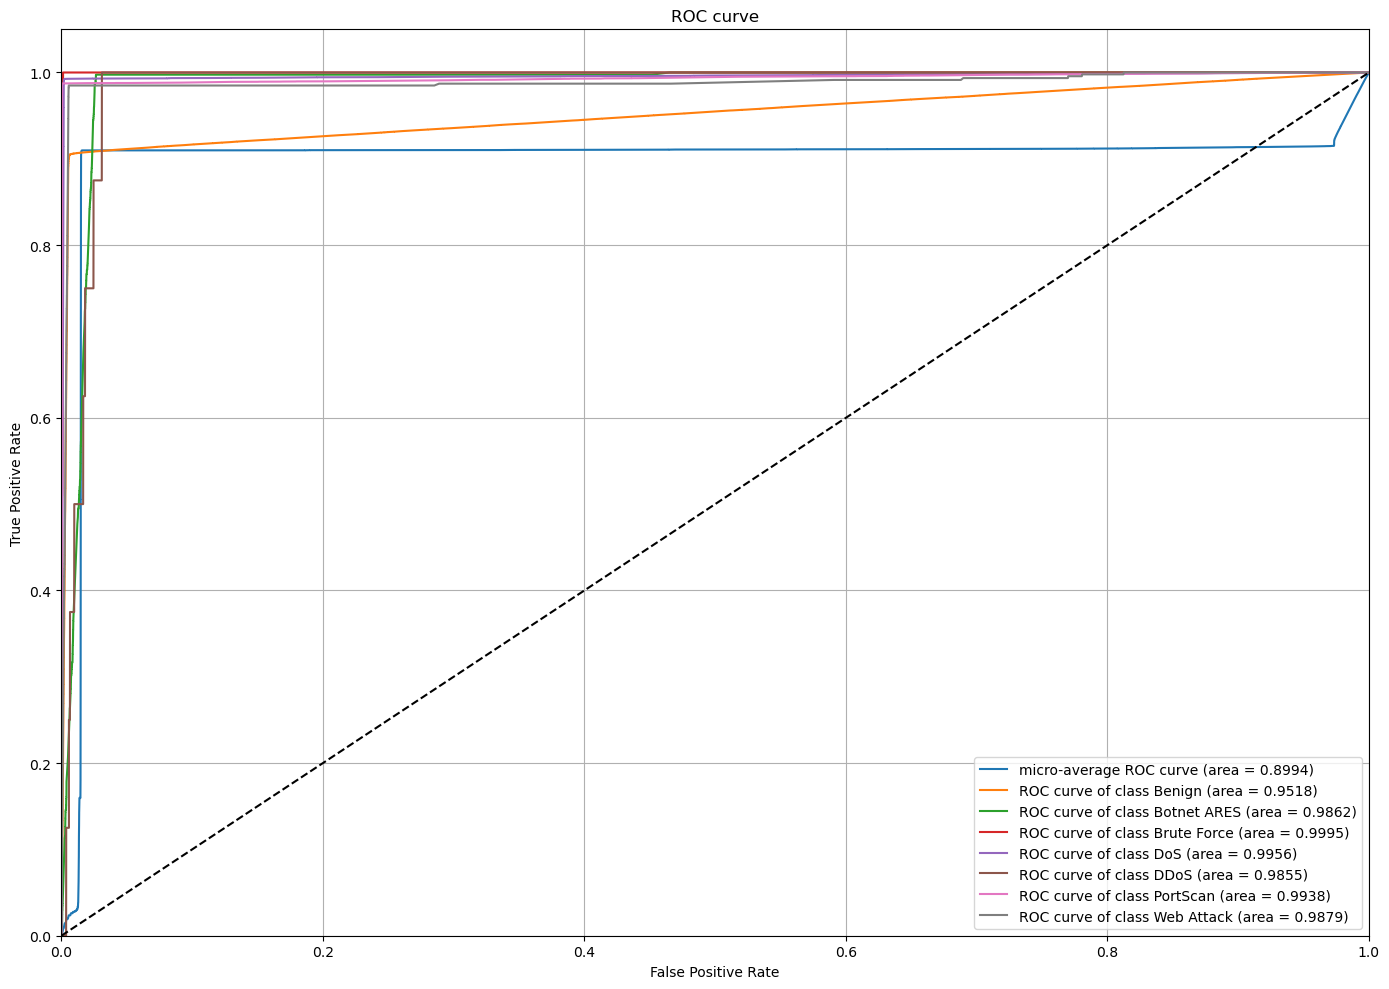

In [21]:
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="imb_cw_dbn_roc_curve2.pdf")

### Plot Precision vs. Recall curve

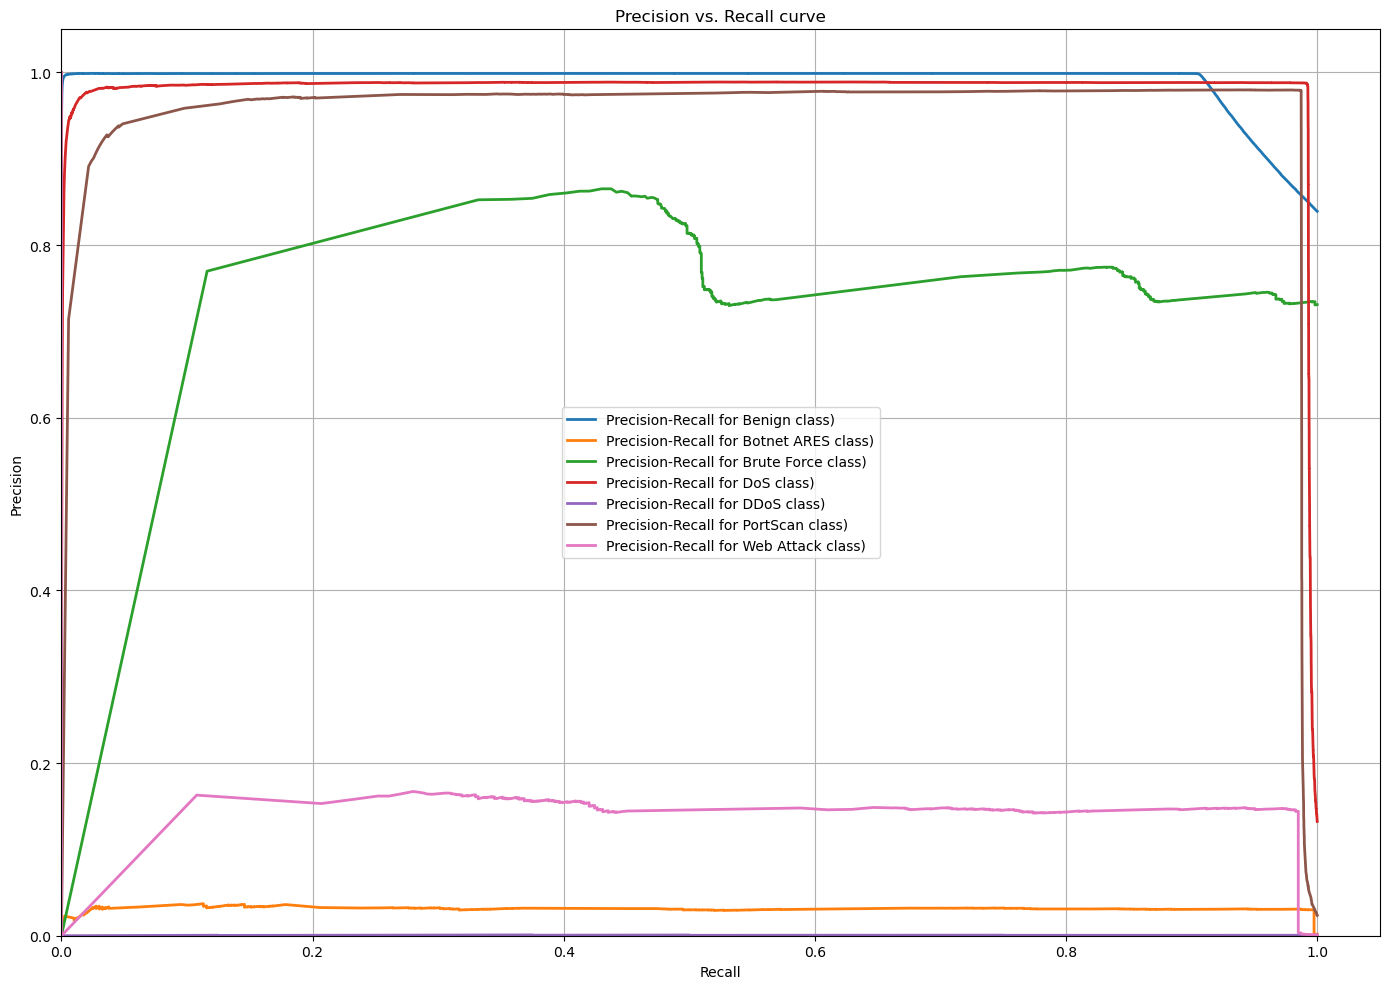

In [22]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="imb_cw_dbn_prec_recall_curve2.pdf")